# Data Access on the Planetary Computer

In this notebook, we'll take a whirlwind tour of accessing geospatial data in many flavors. A few things to note as we go through it:

1. We'll be using cloud-friendly formats
    - We'll stream the data directly from Blob Storage into memory. No downloading to local disk!
2. We'll always start with the STAC API
    - No need to remember URLs / paths in blob storage

In [1]:
import urllib.request
import operator
import functools
import warnings
import requests

import dask.distributed
import pystac_client
import planetary_computer
import stackstac
import numpy as np
import geopandas
import dask.dataframe
import dask_geopandas
import fsspec
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import PIL
import seaborn as sns
import pyproj
import pdal
import shapely.geometry
import shapely.ops

warnings.filterwarnings("ignore", message="pandas.Float64Index")

We'll make a `catalog` client to interact with the Planetary Computer's STAC API.

In [2]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1"
)

And we'll make a local Dask "cluster" to do some computations in parallel.

In [3]:
client = dask.distributed.Client()
client

distributed.diskutils - INFO - Found stale lock file and directory '/home/jovyan/pc-cng-outreach-2022/dask-worker-space/worker-4xaqwa_1', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/jovyan/pc-cng-outreach-2022/dask-worker-space/worker-yk5rzsxg', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/jovyan/pc-cng-outreach-2022/dask-worker-space/worker-m93vr3au', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/jovyan/pc-cng-outreach-2022/dask-worker-space/worker-cb6hw7s6', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/taugspurger/proxy/8787/status,
Dashboard: /user/taugspurger/proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 7.50 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34585,Workers: 4
Dashboard: /user/taugspurger/proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 7.50 GiB
Comm: tcp://127.0.0.1:36411,Total threads: 1
Dashboard: /user/taugspurger/proxy/33271/status,Memory: 1.88 GiB
Nanny: tcp://127.0.0.1:39861,


## Raster Data

Raster data is typically stored as Cloud Optimized GeoTIFF. Some examples include

* Satellite imagery / aerial photography
    - [Landsat C2-L2](https://planetarycomputer.microsoft.com/dataset/landsat-8-c2-l2)
    - [Sentinel 2 L2A](https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a)
    - [NAIP](https://planetarycomputer.microsoft.com/dataset/naip)
* Land use / land cover
    - [Esri / IO 10-Meter Land Cover](https://planetarycomputer.microsoft.com/dataset/io-lulc-9-class)
    - [Land Cover of Canada](https://planetarycomputer.microsoft.com/dataset/nrcan-landcover)
* Elevation
    - [COP DEM](https://planetarycomputer.microsoft.com/dataset/cop-dem-glo-30)
    - [NASADEM](https://planetarycomputer.microsoft.com/dataset/nasadem)
* "Derived variables"
    - [Chloris Biomass](https://planetarycomputer.microsoft.com/dataset/chloris-biomass)
    - [HGB](https://planetarycomputer.microsoft.com/dataset/hgb)
    - [HREA](https://planetarycomputer.microsoft.com/dataset/hrea)



Here we use the STAC API to search for Sentinel-2 scenes matching some spatio-temporal query. We're even able to query on additional properties in the STAC metadata, like the `cloud_cover`.

In [4]:
search = catalog.search(
    bbox=[-122.28, 47.55, -121.96, 47.75],
    datetime="2020-01-01/2020-12-31",
    collections=["sentinel-2-l2a"],
    query={"eo:cloud_cover": {"lt": 25}},
)

items = search.get_all_items()
print(len(items))

36


Whenever you're working with the Planetary Computer, you need to "sign" your items / assets. This appends a read-only SAS token to the data, so that we can fetch the data from Blob Storage.

In [5]:
signed_items = planetary_computer.sign(items)

STAC is all about *metadata*. So these STAC items are just some objects with links to the actual data (COGs in this case). There are lots of ways to go from a URL to an image, or from a list of STAC items to an image. In this case, we'll use `stackstac` which lets you stack your STAC items into an `xarray.DataArray`.

In [6]:
data = stackstac.stack(
    signed_items,
    assets=["B04", "B08"],  # red, nir
    resolution=100,
).where(
    lambda x: x > 0, other=np.nan
)  # sentinel-2 uses 0 as nodata
data

,Array,Chunk
Bytes,663.46 MiB,8.00 MiB
Shape,"(36, 2, 1099, 1099)","(1, 1, 1024, 1024)"
Count,1008 Tasks,288 Chunks
Type,float64,numpy.ndarray


Let's do a little computation: we'll compute NDVI:

In [7]:
red = data.sel(band="B04")
nir = data.sel(band="B08")

ndvi = (red - nir) / (red + nir)

And we'll plot it for the first time slice:

In [8]:
x = ndvi.isel(time=0).persist()
m = stackstac.show(x, range=(-0.9, 0.9), cmap="RdBu")
m.scroll_wheel_zoom = True
m

Map(center=[47.355259207268794, -122.26688848911499], controls=(ZoomControl(options=['position', 'zoom_in_text…

## Earth systems data

These datasets are typically stored as Zarr or NetCDF.

* Climate model output
    - Terraclimate, gridMet, Daymet, NEX-GDDP-CMIP6
* Reanalysis
    - ERA5
* Observations
    - GPM IMERG

In this example, we'll load up some data from Terraclimate.

In [9]:
terraclimate = catalog.get_collection("terraclimate")
asset = terraclimate.assets["zarr-https"]


store = fsspec.get_mapper(asset.href)
ds = xr.open_zarr(store, **asset.extra_fields["xarray:open_kwargs"])
ds

,Array,Chunk
Bytes,103.45 GiB,94.92 MiB
Shape,"(744, 4320, 8640)","(12, 1440, 1440)"
Count,1117 Tasks,1116 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,103.45 GiB,94.92 MiB
Shape,"(744, 4320, 8640)","(12, 1440, 1440)"
Count,1117 Tasks,1116 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


Again, we have a DataArray. We can select the last time slice and plot `tmax` for the globe.

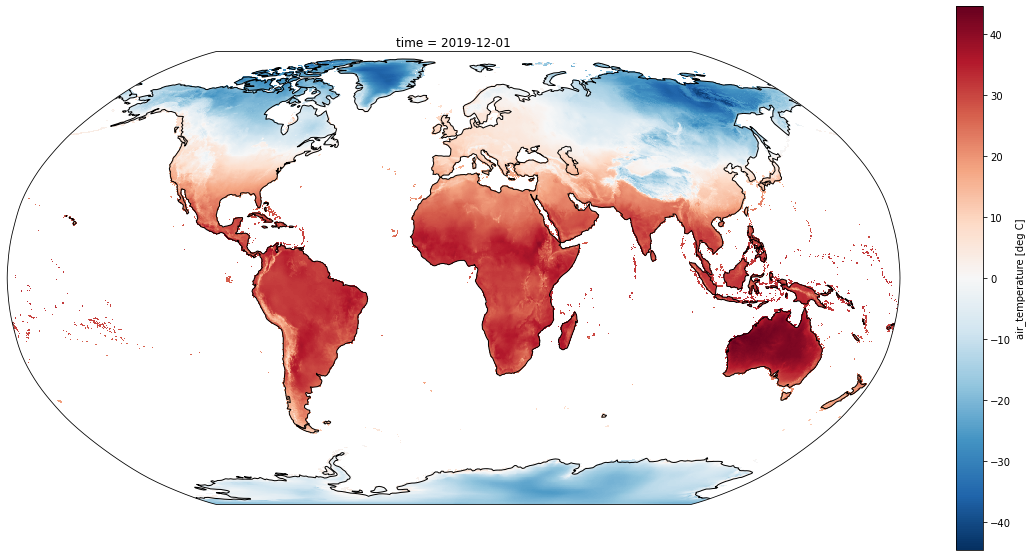

In [10]:
average_max_temp = ds.isel(time=-1)["tmax"].coarsen(lat=8, lon=8).mean().load()

fig, ax = plt.subplots(figsize=(20, 10), subplot_kw=dict(projection=ccrs.Robinson()))

average_max_temp.plot(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines();

Not all Earth Systems datasets are distributed as Zarr. Some data providers use NetCDF / HDF5, which isn't the most cloud-friendly.

For these datasets, we're exploring a "cloud-optimized NetCDF" approach. We scan the files ahead of time to extract some metadata (things like the dimenison names, coordinate labels, attrs) and the necessary byte-range offsets for each data varaible. Then we write that metadata and offsets to a [Kerchunk](https://fsspec.github.io/kerchunk/) index file.

In [11]:
collection = catalog.get_collection("nasa-nex-gddp-cmip6")
references = requests.get(collection.assets["ACCESS-CM2.historical"].href).json()
references = planetary_computer.sign(references)

In [12]:
%%time
ds = xr.open_dataset(
    fsspec.filesystem("reference", fo=references).get_mapper("/"),
    engine="zarr",
    backend_kwargs={"consolidated": False},
    chunks={},
)
ds

CPU times: user 1.64 s, sys: 13.9 ms, total: 1.65 s
Wall time: 1.79 s


<xarray.Dataset>
Dimensions:  (time: 23741, lat: 600, lon: 1440)
Coordinates:
  * lat      (lat) float64 -59.88 -59.62 -59.38 -59.12 ... 89.38 89.62 89.88
  * lon      (lon) float64 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
  * time     (time) datetime64[us] 1950-01-01T12:00:00 ... 2014-12-31T12:00:00
Data variables:
    hurs     (time, lat, lon) float32 dask.array<chunksize=(1, 600, 1440), meta=np.ndarray>
    huss     (time, lat, lon) float32 dask.array<chunksize=(1, 600, 1440), meta=np.ndarray>
    pr       (time, lat, lon) float32 dask.array<chunksize=(1, 600, 1440), meta=np.ndarray>
    rlds     (time, lat, lon) float32 dask.array<chunksize=(1, 600, 1440), meta=np.ndarray>
    rsds     (time, lat, lon) float32 dask.array<chunksize=(1, 600, 1440), meta=np.ndarray>
    sfcWind  (time, lat, lon) float32 dask.array<chunksize=(1, 600, 1440), meta=np.ndarray>
    tas      (time, lat, lon) float32 dask.array<chunksize=(1, 600, 1440), meta=np.ndarray>
    tasmax   (time, lat, lon) float32 dask.array<chunksize=(1, 600, 1440), meta=np.ndarray>
    tasmin   (time, lat, lon) float32 dask.array<chunksize=(1, 600, 1440), meta=np.ndarray>
Attributes: (12/22)
    Conventions:           CF-1.7
    activity:              NEX-GDDP-CMIP6
    cmip6_institution_id:  CSIRO-ARCCSS
    cmip6_license:         CC-BY-SA 4.0
    cmip6_source_id:       ACCESS-CM2
    contact:               Dr. Rama Nemani: rama.nemani@nasa.gov, Dr. Bridget...
    ...                    ...
    scenario:              historical
    source:                BCSD
    title:                 ACCESS-CM2, r1i1p1f1, historical, global downscale...
    tracking_id:           16d27564-470f-41ea-8077-f4cc3efa5bfe
    variant_label:         r1i1p1f1
    version:               1.0

## Operational forecast data

The Planetary Computer also includes some operational weather forecast data. These are typically stored as Zarr or GRIB2. In this example we'll load some data from the ECMWF's Open Data program (using the staging API. It'll be available through the production API soon)

In [13]:
staging_catalog = pystac_client.Client.open(
    "https://planetarycomputer-staging.microsoft.com/api/stac/v1"
)
search = staging_catalog.search(
    collections=["ecmwf-forecast"],
    query={
        "ecmwf:stream": {"eq": "wave"},
        "ecmwf:type": {"eq": "fc"},
        "ecmwf:step": {"eq": "0h"},
    },
)
items = search.get_all_items()
item = items[0]
item

<Item id=ecmwf-2022-04-14T00-wave-fc-0h>

The GRIB2 file and libraries for working with it also aren't that cloud-friendly. We're working on that, but in the meantime we'll download the file to disk and load it from there. Again into an `xarray.DataArray`.

In [14]:
url = item.assets["data"].href
filename, _ = urllib.request.urlretrieve(url)

ds = xr.open_dataset(filename, engine="cfgrib")
ds

<xarray.Dataset>
Dimensions:     (latitude: 451, longitude: 900)
Coordinates:
    time        datetime64[ns] ...
    step        timedelta64[ns] ...
    meanSea     float64 ...
  * latitude    (latitude) float64 90.0 89.6 89.2 88.8 ... -89.2 -89.6 -90.0
  * longitude   (longitude) float64 -180.0 -179.6 -179.2 ... 178.8 179.2 179.6
    valid_time  datetime64[ns] ...
Data variables:
    swh         (latitude, longitude) float32 ...
    mwd         (latitude, longitude) float32 ...
    mwp         (latitude, longitude) float32 ...
    pp1d        (latitude, longitude) float32 ...
    mp2         (latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-04-19T17:27 GRIB to CDM+CF via cfgrib-0.9.1...

Let's make another plot, thise time for "significant wave height".

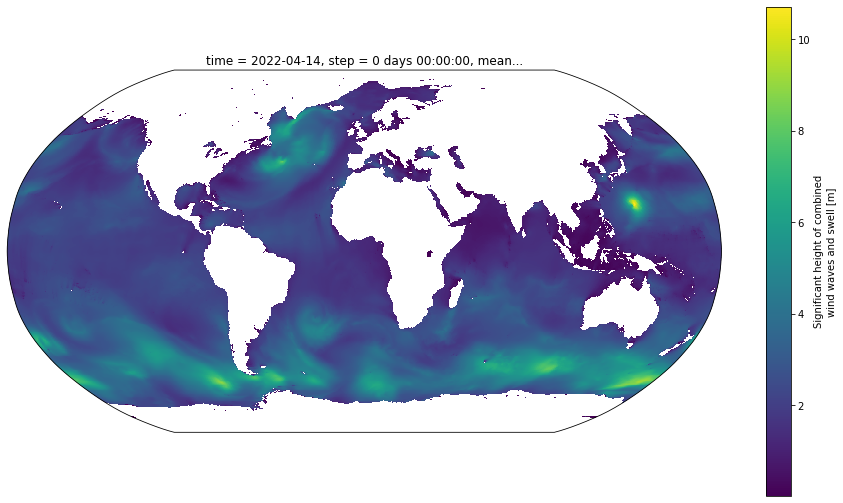

In [15]:
projection = projection = ccrs.Robinson()
fig, ax = plt.subplots(figsize=(16, 9), subplot_kw=dict(projection=projection))

ds.swh.plot(ax=ax, transform=ccrs.PlateCarree());

Or we can plot the join distribution of the "mean wave period" and "significant wave height".

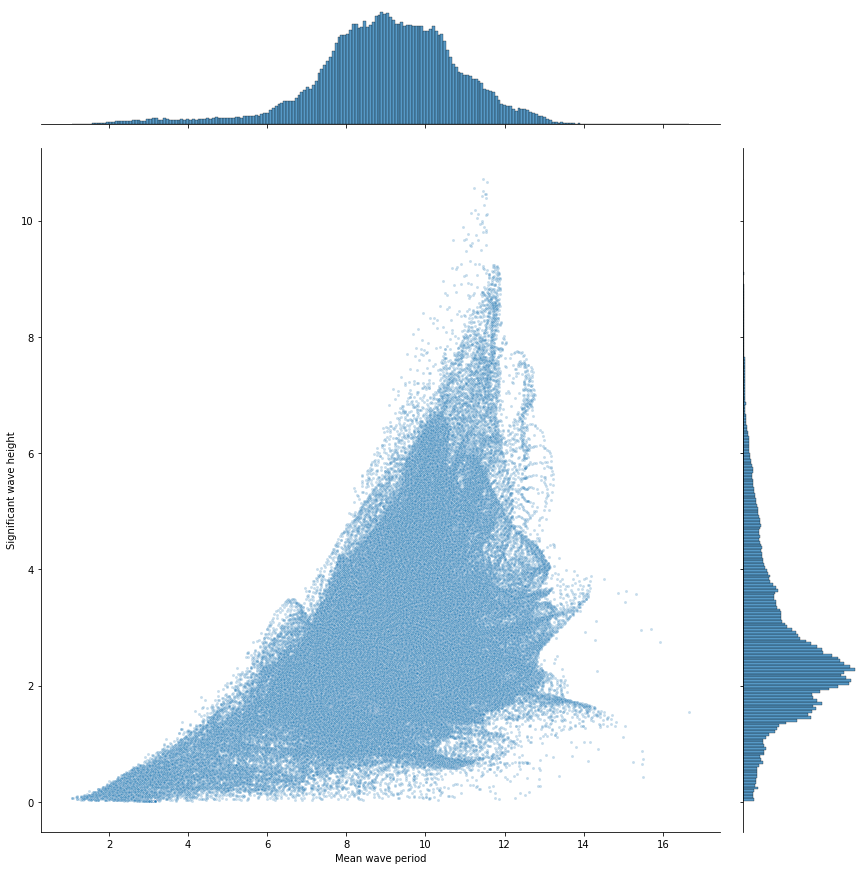

In [16]:
grid = sns.jointplot(
    x=ds.mwp.data.ravel(), y=ds.swh.data.ravel(), alpha=0.25, marker=".", height=12
)
grid.ax_joint.set(xlabel="Mean wave period", ylabel="Significant wave height");

## Tabular data

These are typically stored in Apache Parquet, using the geoparquet standard where appropriate.

- US Census
- Forest Inventory and Analysis
- gNATSGO tables

In this example, we'll load up the Census 2020 Congressional District boundaries.

In [17]:
search = catalog.search(collections=["us-census"])
items = planetary_computer.sign(search.get_all_items())
items = {x.id: x for x in items}
item = items["2020-cb_2020_us_cd116_500k"]
item

<Item id=2020-cb_2020_us_cd116_500k>

That STAC item as a link a Parquet file in Blob Storage. We'll load it up with geopandas.

In [18]:
asset = item.assets["data"]
df = geopandas.read_parquet(
    asset.href, storage_options=asset.extra_fields["table:storage_options"]
)
df

,STATEFP,CD116FP,AFFGEOID,GEOID,NAMELSAD,LSAD,CDSESSN,ALAND,AWATER,geometry
0,06,42,5001600US0642,0642,Congressional District 42,C2,116,2424753563,44105315,"POLYGON ((-117.67629 33.88882, -117.65488 33.8..."
1,39,7,5001600US3907,3907,Congressional District 7,C2,116,10010016396,64562455,"MULTIPOLYGON (((-82.55933 40.78975, -82.55835 ..."
2,48,3,5001600US4803,4803,Congressional District 3,C2,116,1245574011,97890112,"POLYGON ((-96.84410 32.98891, -96.84403 32.992..."
3,28,2,5001600US2802,2802,Congressional District 2,C2,116,40278711117,951654563,"POLYGON ((-91.36371 31.78036, -91.35951 31.799..."
4,42,18,5001600US4218,4218,Congressional District 18,C2,116,757655195,19985421,"POLYGON ((-80.17834 40.33725, -80.17537 40.338..."
...,...,...,...,...,...,...,...,...,...,...
436,26,1,5001600US2601,2601,Congressional District 1,C2,116,64824859099,75781913171,"MULTIPOLYGON (((-83.21216 45.05173, -83.21039 ..."
437,36,3,5001600US3603,3603,Congressional District 3,C2,116,659986401,302111406,"MULTIPOLYGON (((-73.76470 40.81160, -73.76435 ..."
438,48,16,5001600US4816,4816,Congressional District 16,C2,116,1841189026,3570589,"POLYGON ((-106.64548 31.89867, -106.64084 31.9..."
439,06,24,5001600US0624,0624,Congressional District 24,C2,116,17825148853,3683946407,"MULTIPOLYGON (((-119.04704 33.48382, -119.0384..."


And plot the districts for Maryland (with a state FIPS code of `24`).

In [19]:
maryland = df[df.STATEFP == "24"].astype({"GEOID": "category"})
maryland.explore(column="GEOID")

The largest datasets from this collection are at the census-block level. This datasets would be too large to load with pandas or geopandas, which wants all of the data to fit in RAM. So we'll use `dask_geopandas` to load in the geometries data.

In [20]:
asset = items["2020-census-blocks-geo"].assets["data"]

geo = dask_geopandas.read_parquet(
    asset.href,
    storage_options=asset.extra_fields["table:storage_options"],
)
geo

,STATEFP,COUNTYFP,TRACTCE,BLOCKCE,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
npartitions=56,,,,,,,,,
010010201001000,category[unknown],category[unknown],int64,int64,int64,int64,float64,float64,geometry
020130001001000,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...
780109701001000,...,...,...,...,...,...,...,...,...
780309900000008,...,...,...,...,...,...,...,...,...


And `dask.dataframe` to load in the population data.

In [21]:
asset = items["2020-census-blocks-population"].assets["data"]

pop = dask.dataframe.read_parquet(
    asset.href,
    storage_options=asset.extra_fields["table:storage_options"],
)
pop

,P0010001,P0010002,P0010003,P0010004,P0010005,P0010006,P0010007,P0010008,P0010009,P0010010,P0010011,P0010012,P0010013,P0010014,P0010015,P0010016,P0010017,P0010018,P0010019,P0010020,P0010021,P0010022,P0010023,P0010024,P0010025,P0010026,P0010027,P0010028,P0010029,P0010030,P0010031,P0010032,P0010033,P0010034,P0010035,P0010036,P0010037,P0010038,P0010039,P0010040,P0010041,P0010042,P0010043,P0010044,P0010045,P0010046,P0010047,P0010048,P0010049,P0010050,P0010051,P0010052,P0010053,P0010054,P0010055,P0010056,P0010057,P0010058,P0010059,P0010060,P0010061,P0010062,P0010063,P0010064,P0010065,P0010066,P0010067,P0010068,P0010069,P0010070,P0010071,P0020001,P0020002,P0020003,P0020004,P0020005,P0020006,P0020007,P0020008,P0020009,P0020010,P0020011,P0020012,P0020013,P0020014,P0020015,P0020016,P0020017,P0020018,P0020019,P0020020,P0020021,P0020022,P0020023,P0020024,P0020025,P0020026,P0020027,P0020028,P0020029,P0020030,P0020031,P0020032,P0020033,P0020034,P0020035,P0020036,P0020037,P0020038,P0020039,P0020040,P0020041,P0020042,P0020043,P0020044,P0020045,P0020046,P0020047,P0020048,P0020049,P0020050,P0020051,P0020052,P0020053,P0020054,P0020055,P0020056,P0020057,P0020058,P0020059,P0020060,P0020061,P0020062,P0020063,P0020064,P0020065,P0020066,P0020067,P0020068,P0020069,P0020070,P0020071,P0020072,P0020073
npartitions=52,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
010010201001000,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64
020130001001000,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
720019563001000,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

We can join those together.

In [22]:
df = geo.join(pop)
df

,STATEFP,COUNTYFP,TRACTCE,BLOCKCE,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,P0010001,P0010002,P0010003,P0010004,P0010005,P0010006,P0010007,P0010008,P0010009,P0010010,P0010011,P0010012,P0010013,P0010014,P0010015,P0010016,P0010017,P0010018,P0010019,P0010020,P0010021,P0010022,P0010023,P0010024,P0010025,P0010026,P0010027,P0010028,P0010029,P0010030,P0010031,P0010032,P0010033,P0010034,P0010035,P0010036,P0010037,P0010038,P0010039,P0010040,P0010041,P0010042,P0010043,P0010044,P0010045,P0010046,P0010047,P0010048,P0010049,P0010050,P0010051,P0010052,P0010053,P0010054,P0010055,P0010056,P0010057,P0010058,P0010059,P0010060,P0010061,P0010062,P0010063,P0010064,P0010065,P0010066,P0010067,P0010068,P0010069,P0010070,P0010071,P0020001,P0020002,P0020003,P0020004,P0020005,P0020006,P0020007,P0020008,P0020009,P0020010,P0020011,P0020012,P0020013,P0020014,P0020015,P0020016,P0020017,P0020018,P0020019,P0020020,P0020021,P0020022,P0020023,P0020024,P0020025,P0020026,P0020027,P0020028,P0020029,P0020030,P0020031,P0020032,P0020033,P0020034,P0020035,P0020036,P0020037,P0020038,P0020039,P0020040,P0020041,P0020042,P0020043,P0020044,P0020045,P0020046,P0020047,P0020048,P0020049,P0020050,P0020051,P0020052,P0020053,P0020054,P0020055,P0020056,P0020057,P0020058,P0020059,P0020060,P0020061,P0020062,P0020063,P0020064,P0020065,P0020066,P0020067,P0020068,P0020069,P0020070,P0020071,P0020072,P0020073
npartitions=57,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
010010201001000,category[unknown],category[unknown],int64,int64,int64,int64,float64,float64,geometry,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64
020130001001000,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
780109701001000,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

Notice that all those operations were instant. Dask is (mostly) lazy, so it only evaluates when you ask it to.

Theses census-block levels are actually parquet datasets (a folder of files) partitioned by state. So we can do things at a state-level without having to look at the rest of the data.

In [23]:
start = [x for x in geo.divisions if x.startswith("44")][0]
stop = "4499"

ri = geo.loc[start:stop].compute()
ri.head()

,STATEFP,COUNTYFP,TRACTCE,BLOCKCE,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
GEOID,,,,,,,,,
440010301001000,44,001,30100,1000,5329,0,41.765149,-71.333153,"POLYGON ((-71.33394 41.76482, -71.33266 41.765..."
440010301001001,44,001,30100,1001,6001,0,41.765003,-71.332271,"POLYGON ((-71.33301 41.76503, -71.33235 41.765..."
440010301001002,44,001,30100,1002,11821,0,41.764453,-71.332507,"POLYGON ((-71.33343 41.76474, -71.33324 41.764..."
440010301001003,44,001,30100,1003,16049,0,41.763871,-71.332863,"POLYGON ((-71.33430 41.76413, -71.33410 41.764..."
440010301001004,44,001,30100,1004,5398,0,41.764249,-71.334446,"POLYGON ((-71.33524 41.76393, -71.33394 41.764..."


## Point-cloud data

Typically stored as COPC.

In [24]:
bean = {"type": "Point", "coordinates": [-87.623358, 41.8826812]}

geom = shapely.geometry.shape(bean)

utm = pyproj.crs.CRS.from_epsg(32616)  # UTM zone for Chicago
wgs84 = pyproj.CRS("EPSG:4326")

project_dd_to_utm = pyproj.Transformer.from_crs(wgs84, utm, always_xy=True).transform
project_utm_to_dd = pyproj.Transformer.from_crs(utm, wgs84, always_xy=True).transform

utm_point = shapely.ops.transform(project_dd_to_utm, geom)
window = utm_point.buffer(400)

window_dd = shapely.ops.transform(project_utm_to_dd, window)

df = geopandas.GeoDataFrame(geometry=[window_dd], crs="EPSG:4326")

df.explore()

In [25]:
# The Bean
bean = shapely.geometry.shape(
    {"type": "Point", "coordinates": [-87.623358, 41.8826812]}
).buffer(0.005)

# The *test* API. Really bleeding-edge now.

test_catalog = pystac_client.Client.open(
    "https://pct-apis-staging.westeurope.cloudapp.azure.com/stac/"
)

search = test_catalog.search(collections=["3dep-lidar-copc"], intersects=bean)
ic = search.get_all_items()

# Filter out for only the Cook County LiDAR collections
cook = []
for item in ic:
    if "Cook" in item.id:
        cook.append(item)

signed = [planetary_computer.sign(i) for i in cook]

In [26]:
OUTPUT_RESOLUTION = 2.0
READ_RESOLUTION = 2.0
polygon = window.wkt + f" / EPSG:{utm.to_epsg()}"

readers = []
for tile in signed:
    url = tile.assets["data"].href
    reader = pdal.Reader.copc(
        url, requests=3, resolution=READ_RESOLUTION, polygon=polygon
    )
    readers.append(reader)


assign = pdal.Filter.assign(value=["Intensity = Intensity / 256"])

writer = pdal.Writer.gdal(
    "intensity.tif",
    resolution=OUTPUT_RESOLUTION,
    dimension="Intensity",
    data_type="uint8",
    output_type="mean",
)

In [27]:
pipeline = None

pipeline = functools.reduce(operator.or_, readers)
pipeline |= assign | writer

In [28]:
%%time

# Use streaming mode at 1e6 points at a time. This
# helps us conserve memory for pipelines that are streamable
# check that with the pipeline.streamable property
results = pipeline.execute_streaming(chunk_size=1000000)
print(pipeline.log)

# the last stage of our pipeline is the writer, and the 'dimension'
# option on the writer is what we want to print
dimension = pipeline.stages[-1].options["dimension"]
print(f"Number of points returned for dimension {dimension}: {results}")


Number of points returned for dimension Intensity: 1047992
CPU times: user 26 s, sys: 943 ms, total: 26.9 s
Wall time: 25.8 s


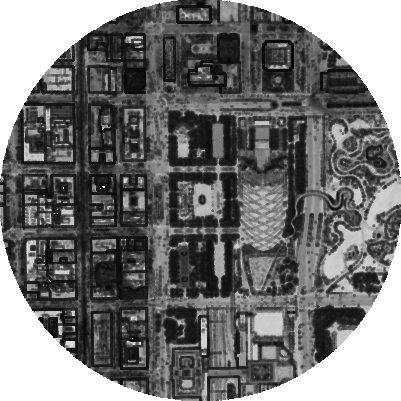

In [29]:
PIL.Image.open("intensity.tif")